In [1]:
import os, sys, re
import nltk
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num

from datetime import datetime, date, time, timedelta
from collections import defaultdict
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

sys.path.append(os.path.join(os.path.dirname('.'), '..'))
from common import get_dataset

In [2]:
exclude_headers = [
    "Message-ID:",
    "From:",
    "To:",
    "Subject:",
    "Mime-Version:",
    "Content-Type:",
    "Content-Transfer-Encoding:",
    "X-From:",
    "X-To:",
    "X-cc: ",
    "X-bcc: ",
    "X-Folder:",
    "X-Origin:",
    "X-FileName:"
]

In [3]:
def load_data(dataset, text_list, time_list):
    date_tag = "Date:"
    for _, files in dataset.items():
        for file in files:
            with open(os.path.join('..', file), 'r') as fp:
                lines = fp.readlines()
                stripped = []
                for line in lines:
                    remove = False
                    if date_tag in line:
                        curr_time = line
                        remove = True 
                    for t in exclude_headers:
                        if t in line:
                            remove = True
                    if remove:
                        continue
                    stripped.append(line)
                tokens = [i for i in nltk.wordpunct_tokenize(''.join(stripped).lower())]

                text_list.append(' '.join(tokens))
                time_list.append(curr_time)


In [4]:
def get_sentiment(out):
	if out['pos'] > out['neg']:
		return 'pos'
	elif out['neg'] > out['pos']:
		return 'neg'
	else:
		return 'neu'

In [5]:
def get_time_bin(timestamp):
    match = re.search(r'\d{2}:\d{2}:\d{2}', timestamp).group().split(':')
    val = int(match[0]) * 60 * 60 + int(match[1]) * 60 + int(match[2])
    return val // (30 * 60)

In [6]:
train, test = get_dataset(dataset_dir=os.path.join('..', 'dataset'))
texts, timestamps = [], [] 
load_data(train, texts, timestamps)
load_data(test, texts, timestamps)

In [7]:
sentiment_counter = {
	'pos': 0,
	'neg': 0,
	'neu': 0
}

pos_bins, neg_bins, total_bins = {}, {}, {}
for t in range(48):
	pos_bins[t] = 0
	neg_bins[t] = 0
	total_bins[t] = 0


In [8]:
for i in tqdm(range(len(texts))):
    sid = SentimentIntensityAnalyzer()

    seq = texts[i]
    ss = sid.polarity_scores(seq)
    sentiment = get_sentiment(ss)
    sentiment_counter[sentiment] += 1

    try:
        curr_bin = get_time_bin(timestamps[i])
        if sentiment == 'pos':
            pos_bins[curr_bin] += 1
        else:
            neg_bins[curr_bin] += 1
        total_bins[curr_bin] += 1
    except:
        pass

100%|██████████| 30109/30109 [03:38<00:00, 138.02it/s]


In [9]:
for t in range(48):
	if total_bins[t] == 0:
		continue

	pos_bins[t] = pos_bins[t] / total_bins[t]
	neg_bins[t] = neg_bins[t] / total_bins[t]

In [10]:
pos_vals = np.fromiter(pos_bins.values(), dtype=float)
neg_vals = np.fromiter(neg_bins.values(), dtype=float)

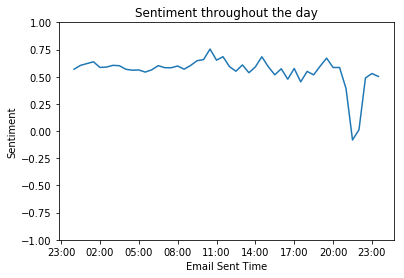

In [11]:
base = time(0, 0, 0)
hour_list = np.array([datetime.combine(date.today(), base) + timedelta(minutes=i*30) for i in range(48)])

plt.plot(hour_list, pos_vals - neg_vals)

xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

plt.xlabel('Email Sent Time')
plt.ylabel('Sentiment')
plt.title('Sentiment throughout the day')
plt.ylim(-1, 1)
plt.savefig('average-sentiment')
plt.show()